# Tłumacz polsko-bułgarski oparty o architekturę transformera

## Biblioteki i ustawienia

In [1]:
import json
import warnings

from torchtext.data import Field, BucketIterator
from tqdm import tqdm
import matplotlib.pyplot as plt
import spacy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from utils import get_dataset_splits, random_eval, get_batch_bleu, print_dataset_info, get_subset

In [2]:
warnings.filterwarnings("ignore")

In [3]:
!python --version

Python 3.12.3


In [4]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cpu')

In [5]:
# training hyperparameters
LEARNING_RATE = 1e-4
NUM_EPOCHS = 50
BATCH_SIZE = 32

# model hyperparameters
EMBEDDING_SIZE = 128
NUM_ENC_LAYERS = 8
NUM_DEC_LAYERS = 8
TOKEN_LIMIT = 32
DIM_FEEDFORWARD = 512
NUM_HEADS = 16
DROPOUT = 0.1

# other
ENABLE_TRAINING = True
SUBSET_RATIO = 0.05
CORPUS_PATH = "./raw_data/"
TRAIN_DATASET_PATH = f"./datasets/train_dataset_{TOKEN_LIMIT}.pkl"
TEST_DATASET_PATH = f"./datasets/test_dataset_{TOKEN_LIMIT}.pkl"
MODEL_PATH = f"./serialized_models/model_v3"

## Tokenizatory

Zaprojektowałem dwa tokenizatory, osobno dla każdego języka. Są one oparte o modele `pl_core_news_lg` i `uk_core_news_lg` z biblioteki `spacy`. Jak widać dla języka bułgarskiego użyty został model przeznaczony dla języka ukraińskiego. Jest to spowodowane brakiem modelu dla języka bułgarskiego w bibliotece `spacy` oraz wysokim podobieństwem tych języków. Zakładam, że nie powinno to negatywnie wpłynąć na jakość tłumaczenia.

In [6]:
nlp_pl = spacy.load("pl_core_news_lg")
nlp_bg = spacy.load("uk_core_news_lg")

In [7]:
def tokenize_pl(text):
    return [token.text for token in nlp_pl.tokenizer(text)]

def tokenize_bg(text):
    return [token.text for token in nlp_bg.tokenizer(text)]

In [8]:
polish = Field(
    tokenize=tokenize_pl, lower=True,
    init_token="<bos>", eos_token="<eos>"
)

bulgarian = Field(
    tokenize=tokenize_bg, lower=True,
    init_token="<bos>", eos_token="<eos>"
)

## Wczytanie danych

In [9]:
fields = [("src", polish), ("tgt", bulgarian)]
train_dataset, test_dataset = get_dataset_splits(
    train_dataset_path=TRAIN_DATASET_PATH,
    test_dataset_path=TEST_DATASET_PATH,
    corpus_path=CORPUS_PATH,
    max_len=TOKEN_LIMIT,
    fields=fields,
)

Loading dataset from: ./datasets/train_dataset_32.pkl
Loading dataset from: ./datasets/test_dataset_32.pkl
Done.

<|TRAIN SET|>
number of examples: 217228
number of source tokens: 755338
number of target tokens: 700961


<|TEST SET|>
number of examples: 24080
number of source tokens: 83504
number of target tokens: 77626



In [10]:
train_dataset = get_subset(train_dataset, SUBSET_RATIO)
test_dataset = get_subset(test_dataset, SUBSET_RATIO)
print_dataset_info(train_dataset, "train")
print_dataset_info(test_dataset, "test")


<|TRAIN SET|>
number of examples: 10861
number of source tokens: 37635
number of target tokens: 35038


<|TEST SET|>
number of examples: 1204
number of source tokens: 4273
number of target tokens: 3942



In [11]:
polish.build_vocab(train_dataset, max_size=10000, min_freq=2)
bulgarian.build_vocab(train_dataset, max_size=10000, min_freq=2)

In [12]:
train_iterator, test_iterator = BucketIterator.splits(
    (train_dataset, test_dataset),
    batch_size=BATCH_SIZE,
    sort_within_batch=True,
    sort_key = lambda x: len(x.src),
    device=DEVICE
)

## Architektura modelu

In [13]:
class PL2BG(nn.Module):
    def __init__(
        self,
        embedding_size,
        src_vocab_size,
        tgt_vocab_size,
        src_pad_idx,
        num_heads,
        num_encoder_layers,
        num_decoder_layers,
        dim_feedforward,
        dropout,
        token_limit,
        device,
    ):
        super(PL2BG, self).__init__()
        self.src_word_embedding = nn.Embedding(src_vocab_size, embedding_size)
        self.tgt_word_embedding = nn.Embedding(tgt_vocab_size, embedding_size)
        self.position_embedding = nn.Embedding(token_limit, embedding_size)
        self.device = device
        self.transformer = nn.Transformer(
            d_model=embedding_size,
            nhead=num_heads,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
        )
        self.fc_1 = nn.Linear(embedding_size, 512)
        self.fc_2 = nn.Linear(512, 512)
        self.fc_3 = nn.Linear(512, 1024)
        self.fc_4 = nn.Linear(1024, embedding_size)
        self.unembedding = nn.Linear(embedding_size, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)
        self.src_pad_idx = src_pad_idx

    def make_src_mask(self, src):
        return src.transpose(0, 1) == self.src_pad_idx

    def forward(self, src, tgt):
        src_seq_len, n = src.shape
        tgt_seq_len = tgt.shape[0]
        src_positions = torch.arange(0, src_seq_len) \
            .unsqueeze(1).expand(src_seq_len, n).to(self.device)
        tgt_positions = torch.arange(0, tgt_seq_len) \
            .unsqueeze(1).expand(tgt_seq_len, n).to(self.device)
        embedded_src = self.dropout(
            self.src_word_embedding(src)
            + self.position_embedding(src_positions)
        )
        embedded_tgt = self.dropout(
            self.tgt_word_embedding(tgt)
            + self.position_embedding(tgt_positions)
        )
        src_padding_mask = self.make_src_mask(src)
        tgt_mask = self.transformer \
            .generate_square_subsequent_mask(tgt_seq_len).to(self.device)
        output = self.transformer(
            embedded_src,
            embedded_tgt,
            src_key_padding_mask=src_padding_mask,
            tgt_mask=tgt_mask
        )
        output = F.relu(self.dropout(self.fc_1(output)))
        output = F.relu(self.dropout(self.fc_2(output)))
        output = F.relu(self.dropout(self.fc_3(output)))
        output = F.relu(self.dropout(self.fc_4(output)))
        return self.unembedding(output)

## Inicjalizacja i trening

In [14]:
tgt_pad_idx = bulgarian.vocab.stoi["<pad>"]
src_pad_idx = polish.vocab.stoi["<pad>"]
tgt_vocab_size = len(bulgarian.vocab)
src_vocab_size = len(polish.vocab)

model = PL2BG(
    num_encoder_layers=NUM_ENC_LAYERS,
    num_decoder_layers=NUM_DEC_LAYERS,
    dim_feedforward=DIM_FEEDFORWARD,
    embedding_size=EMBEDDING_SIZE,
    src_vocab_size=src_vocab_size,
    tgt_vocab_size=tgt_vocab_size,
    src_pad_idx=src_pad_idx,
    token_limit=TOKEN_LIMIT,
    num_heads=NUM_HEADS,
    dropout=DROPOUT,
    device=DEVICE,
).to(DEVICE)

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss(ignore_index=tgt_pad_idx)

In [15]:
layers = [layer.view(1, -1).squeeze().shape[0] for layer in model.parameters()]

model_metadata = {
    "training_hyperparameters": {
        "learning_rate": LEARNING_RATE,
        "num_epochs": NUM_EPOCHS,
        "batch_size": BATCH_SIZE,
    },
    "model_hyperparameters": {
        "embedding_size": EMBEDDING_SIZE,
        "num_enc_layers": NUM_ENC_LAYERS,
        "num_dec_layers": NUM_DEC_LAYERS,
        "dim_feedforward": DIM_FEEDFORWARD,
        "token_limit": TOKEN_LIMIT,
        "num_heads": NUM_HEADS,
        "dropout": DROPOUT,
        "device": str(DEVICE),
    },
    "model_architecture": {
        "num_params": sum(layers),
        "num_layers": len(layers),
    },
    "other": {
        "subset_ratio": SUBSET_RATIO,
        "model_path": MODEL_PATH,
        "train_dataset_path": TRAIN_DATASET_PATH,
        "test_dataset_path": TEST_DATASET_PATH,
        "corpus_path": CORPUS_PATH,
    }
}

In [17]:
if ENABLE_TRAINING:
    print("Training...")

    metrics = {
        "loss": [],
        "train_bleu": [],
        "test_bleu": [],
    }

    for epoch in range(NUM_EPOCHS):

        model.train()
        mean_train_bleu = 0
        mean_test_bleu = 0
        mean_loss = 0

        epoch_num = f"[{epoch + 1:0{len(str(NUM_EPOCHS))}d} / {NUM_EPOCHS}]"
        iterator = tqdm(train_iterator, desc=f"EPOCH {epoch_num}")
        for idx, batch in enumerate(iterator):
            src = batch.src.to(DEVICE)
            tgt = batch.tgt.to(DEVICE)

            out = model(src, tgt[:-1])
            out = out.reshape(-1, out.shape[2])
            _tgt = tgt[1:].reshape(-1)
            optimizer.zero_grad()

            loss = criterion(out, _tgt)

            current_loss = loss.item()
            current_train_bleu = get_batch_bleu(model, src, tgt, bulgarian)
            current_test_bleu = random_eval(
                model=model,
                n_examples=32,
                dataset=test_dataset,
                src_lang=polish,
                tgt_lang=bulgarian,
                device=DEVICE,
                token_limit=TOKEN_LIMIT,
            )["score"]

            mean_loss += current_loss / len(train_iterator)
            mean_train_bleu += current_train_bleu / len(train_iterator)
            mean_test_bleu += current_test_bleu / len(train_iterator)

            if idx == len(train_iterator):
                iterator.set_postfix_str(
                    f"loss={mean_loss:.4f}\t"
                    f"train_bleu={mean_train_bleu:.2f}\t"
                    f"test_bleu={mean_test_bleu:.2f}"
                )
            else:
                iterator.set_postfix_str(
                    f"loss={current_loss:.6f}\t"
                    f"train_bleu={current_train_bleu:.4f}\t"
                    f"test_bleu={current_test_bleu:.4f}"
                )

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
            optimizer.step()

        metrics["loss"].append(mean_loss)
        metrics["train_bleu"].append(mean_train_bleu)
        metrics["test_bleu"].append(mean_test_bleu)

    print("Saving model...")
    json.dump(model_metadata, open(MODEL_PATH + ".json", "w"))
    torch.save(model.state_dict(), MODEL_PATH)

else:
    print("Loading pretrained model...")
    print(model.load_state_dict(torch.load(MODEL_PATH)))

Training...


EPOCH [50 / 50]: 100%|██████████| 340/340 [05:12<00:00,  1.09it/s, loss=0.293843	train_bleu=86.4688	test_bleu=51.4899] 

Saving model...


In [18]:
json.dump(model_metadata, open(MODEL_PATH + ".json", "w"))
torch.save(model.state_dict(), MODEL_PATH)

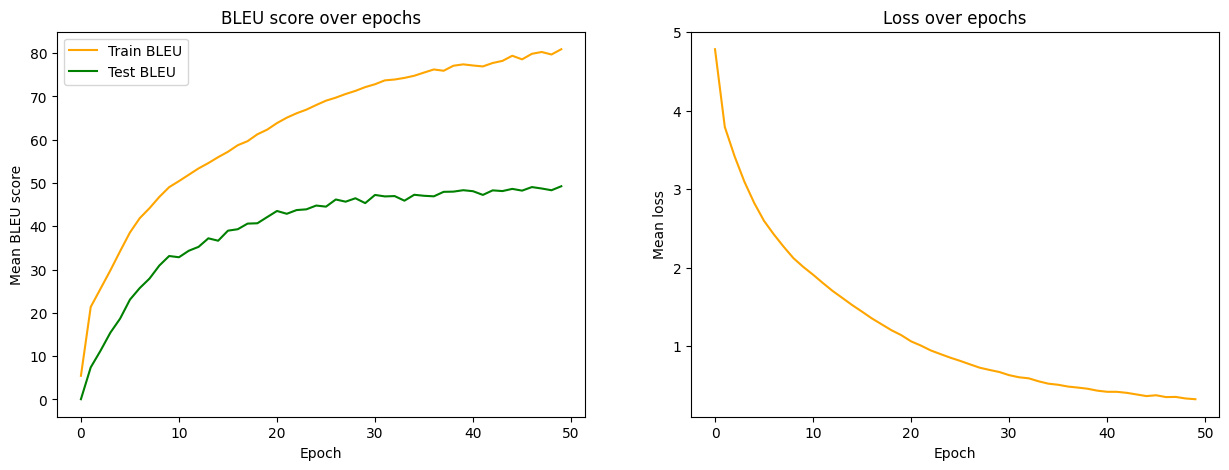

In [19]:
if ENABLE_TRAINING:
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].plot(metrics["train_bleu"], c="orange")
    ax[0].plot(metrics["test_bleu"], c="green")
    ax[0].legend(["Train BLEU", "Test BLEU"])
    ax[0].set_ylabel("Mean BLEU score")
    ax[0].set_xlabel("Epoch")
    ax[0].set_title("BLEU score over epochs")
    ax[1].plot(metrics["loss"], c="orange")
    ax[1].set_ylabel("Mean loss")
    ax[1].set_xlabel("Epoch")
    ax[1].set_title("Loss over epochs")
    plt.savefig(f"{MODEL_PATH}.png", dpi=300)
    plt.show()

## Ewaluacja

In [22]:
evaluation = random_eval(
    model=model,
    n_examples=32,
    dataset=test_dataset,
    src_lang=polish,
    tgt_lang=bulgarian,
    device=DEVICE,
    token_limit=TOKEN_LIMIT,
)
for example in evaluation["examples"]:
    print(example, file=open(f"{MODEL_PATH}.txt", "a"))
print(f"BLEU: {evaluation["score"]}", file=open(f"{MODEL_PATH}.txt", "a"))